In [1]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

## Figure 5 (b)

In [3]:
d = 1
n = 30
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 5
theta_2 = 10

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.7071067811865476

In [4]:
X = gen_observation_points(d, n, sup)
X, X, Y_1, Y_2 = gen_observations(X, X, 
                                  matern_model(theta_1, nu_1), 
                                  matern_model(theta_2, nu_2),
                                  matern_model(theta_12, nu_12),
                                  rho_12)

In [5]:
X_test = np.linspace(0,1,101).reshape(101,1)
# X_test = gen_observation_points(d, 100, sup)

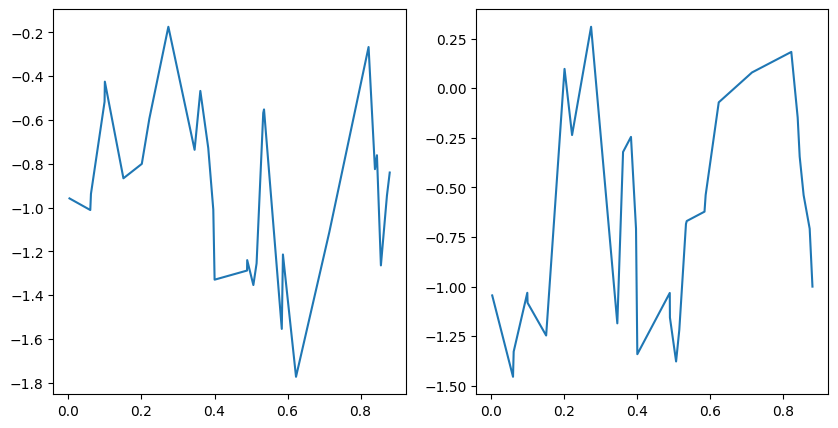

In [6]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

sort_ind = np.argsort(X, axis=0).flatten()
axs[0].plot(X[sort_ind], Y_1[sort_ind])
axs[1].plot(X[sort_ind], Y_2[sort_ind]);

In [7]:
Ns = [2, 5]
As = [
    np.argsort(X, axis=0).reshape(15,2).tolist(),
    np.random.choice(np.arange(n), size=(n//2, 2), replace=False).tolist(),
    # np.random.choice(np.arange(n), size=(n//2, 2), replace=False).tolist()
      ]
rmses_NcoK = []
rmses_coKNN = []

num_iterations = 100

for _ in range(num_iterations):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(As))

    X = gen_observation_points(d, n, sup)
    X, X, Y_1, Y_2 = gen_observations(X,X,matern_model(theta_1,nu_1),matern_model(theta_2,nu_2),matern_model(theta_12,nu_12),rho_12)
    
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, A in enumerate(As):
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)


rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)

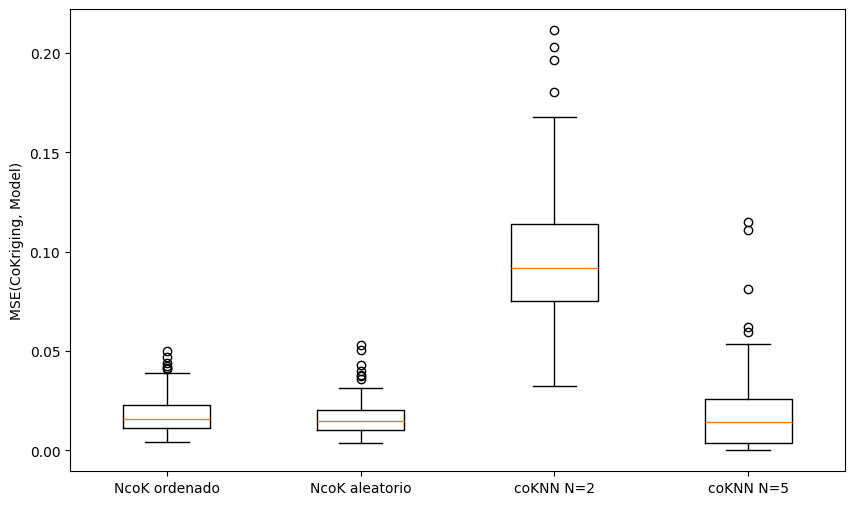

In [8]:
plt.figure(figsize=(10,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 3 + len(Ns)), ['NcoK ordenado', 'NcoK aleatorio'] + [f'coKNN {N=}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.show()

# n = 10_000

In [18]:
d = 2
n = 10_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.8

In [19]:
X = gen_observation_points(d, n, sup)
X, X, Y_1, Y_2 = gen_observations(X, X, 
                                  matern_model(theta_1, nu_1), 
                                  matern_model(theta_2, nu_2),
                                  matern_model(theta_12, nu_12),
                                  rho_12)

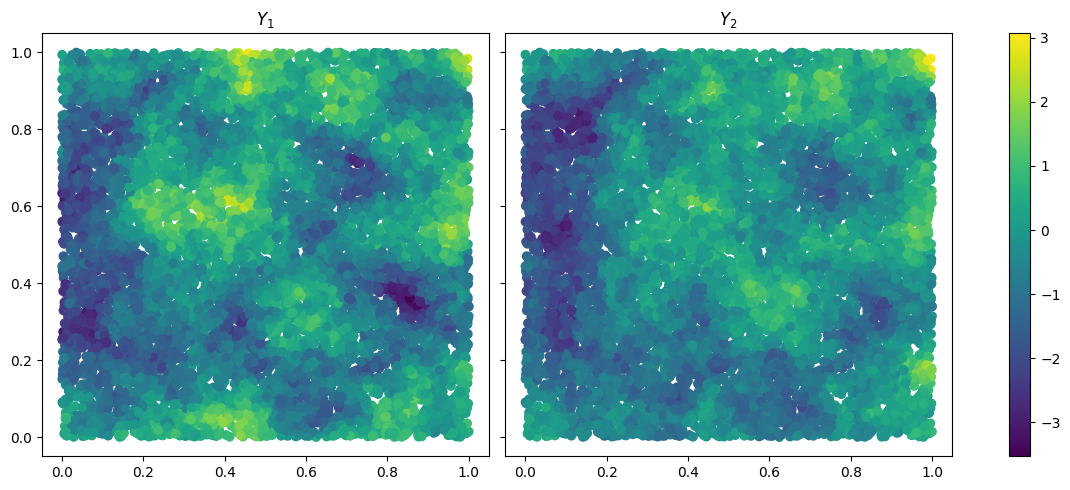

In [20]:
NestedCoKriging(X, X, Y_1, Y_2, cauchy_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [21]:
X_test = gen_observation_points(d, 100, sup)

In [25]:
n * 0.1 // 100

10.0

In [28]:
Ns = [1, 10, 100]
As = [
    gen_A(X, 500),  # 20
    gen_A(X, 200),  # 50
    gen_A(X, 100),  # 100
    ]
rmses_NcoK = []
rmses_coKNN = []

num_replications = 50

for _ in range(num_replications):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(As))

    X = gen_observation_points(d, n, sup)
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    
    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+n))
    Y_1, Y_2 = Y[:n], Y[n:]

    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, A in enumerate(As):
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)

rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)

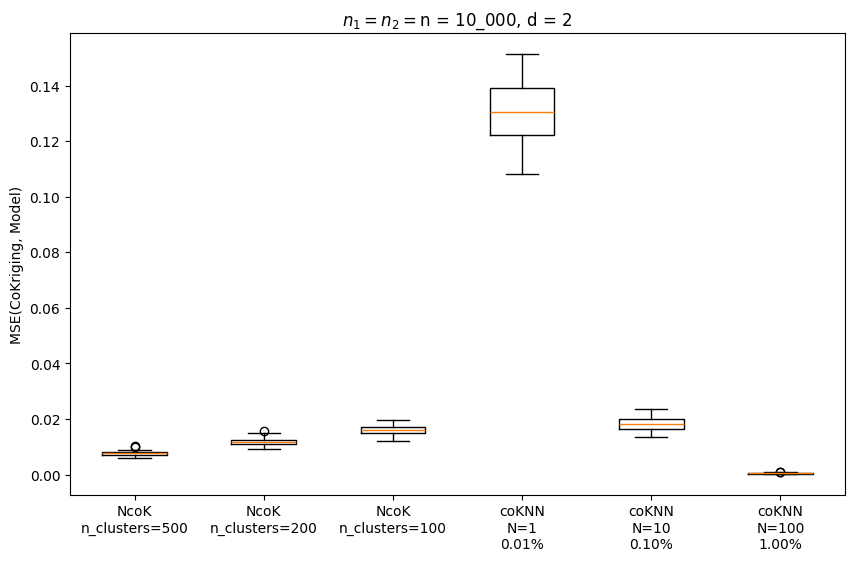

In [38]:
plt.figure(figsize=(10,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + len(As) + len(Ns)), [f'NcoK\n{n_clusters=}' for n_clusters in [500, 200, 100]] + [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

# $d=3$

In [2]:
d = 3
n = 10_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 5

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

0.7155417527999329

In [3]:
X_test = gen_observation_points(d, 100, sup)

In [4]:
n * 0.1 // 100

10.0

In [5]:
Ns = [1, 10, 100]

ns_clusters = [
    1_000, # 10
    500,   # 20
    200,   # 50
    100    # 100
]

rmses_NcoK = []
rmses_coKNN = []

num_replications = 50

for _ in range(num_replications):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(len(ns_clusters))

    X = gen_observation_points(d, n, sup)
# CO KRIGING
    sigma = K(X, X, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
              matern_model(theta_12, nu_12), rho_12)
    
    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n+n))
    Y_1, Y_2 = Y[:n], Y[n:]

    Y_coK = co_kriging(X_test, X, X, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)
    
# CO KRIGING NN
    for i, N in enumerate(Ns):    
        coKNN = coKrigingNN(X, X, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)

# NESTED CO KRIGING
    for i, n_clusters in enumerate(ns_clusters):
        A = gen_A(X, n_clusters)
        NcoK = NestedCoKriging(X, X, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        Y_pred = NcoK.predict(X_test, A, A)
        rmse_NcoK[i] += root_mean_squared_error(Y_coK, Y_pred)
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)
    print(_)

rmses_coKNN = np.array(rmses_coKNN) 
rmses_NcoK = np.array(rmses_NcoK)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


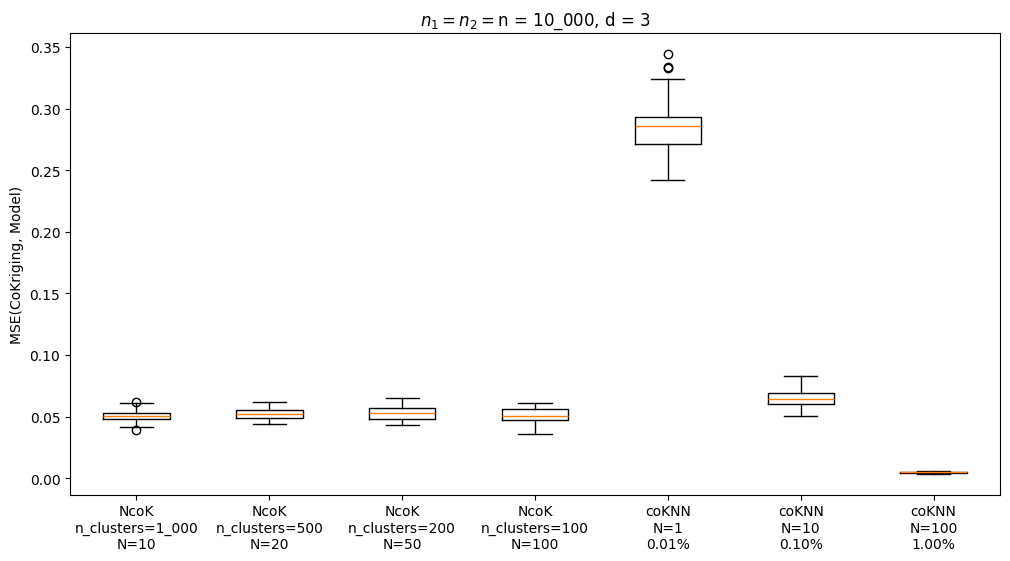

In [6]:
plt.figure(figsize=(12,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + len(ns_clusters) + len(Ns)), [f'NcoK\n{n_clusters=:_.0f}\nN={n//n_clusters}' for n_clusters in ns_clusters] + [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])
plt.ylabel('MSE(CoKriging, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

# NcoK con A ordenada por más cercanos

In [38]:
d = 2
n_1 = 10_000 + 100
n_2 = 1_000
sup = 1

nu_1 = 1/2
nu_2 = 1/2
theta_1 = 4
theta_2 = 3

nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = -(theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)
rho_12

-0.7500000000000001

In [39]:
X_1 = gen_observation_points(d, n_1, sup)
X_2 = gen_observation_points(d, n_2, sup)

In [40]:
sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
            matern_model(theta_12, nu_12), rho_12)

Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n_1+n_2))
Y_1, Y_2 = Y[:n_1], Y[n_1:]

In [41]:
n_test = 100

X_test, Y_test = X_1[:n_test], Y_1[:n_test]
X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

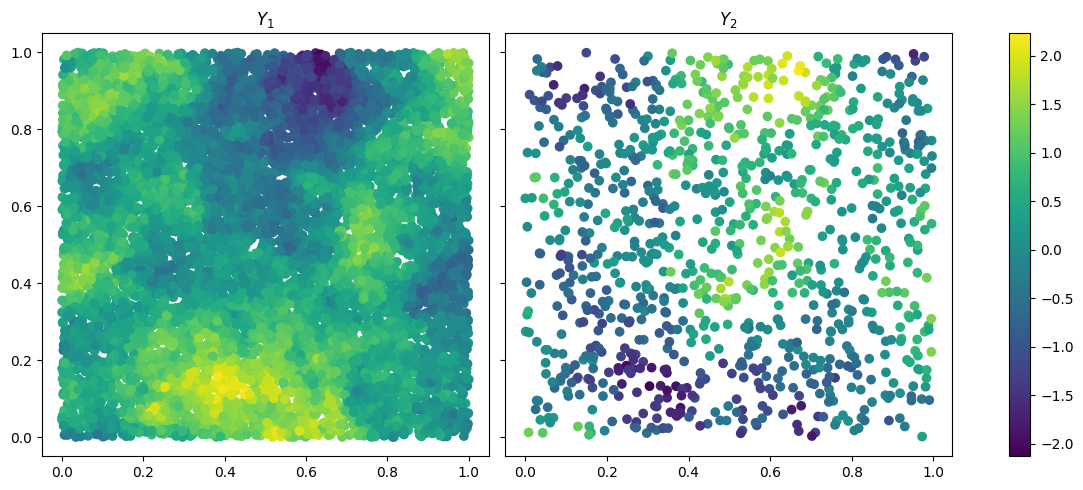

In [42]:
NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, theta_1, theta_2, theta_12, nu_1, nu_2, nu_12, rho_12).plot_obs()

In [49]:
n_clusters = 100

In [ ]:
sigma = sigma[n_test:, :][:, n_test:]

Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

In [54]:
NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                        theta_1, theta_2, theta_12, nu_1,
                        nu_2, nu_12, rho_12)
Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
root_mean_squared_error(Y_pred, Y_test), root_mean_squared_error(Y_pred, Y_coK)

(0.16122437208089427, 0.0015244795093130713)

In [56]:
A_1 = gen_A(X_1, n_clusters)
A_2 = gen_A(X_2, n_clusters)

NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                        theta_1, theta_2, theta_12, nu_1,
                        nu_2, nu_12, rho_12)
Y_pred = NcoK.predict(X_test, A_1, A_2)
root_mean_squared_error(Y_pred, Y_test), root_mean_squared_error(Y_pred, Y_coK)

(0.15974980985845755, 0.024032916081986214)

In [4]:
n_test = 100

In [19]:
Ns = [1, 10, 100]
ns_clusters = [
    100, # 10
    10,  # 100
]
rmses_NcoK = []
rmses_coKNN = []
rmses_NcoK_test = []
rmses_coKNN_test = []

times_NcoK = []
times_coKNN = []

num_replications = 100

for _ in range(num_replications):
    rmse_coKNN = np.zeros(len(Ns))
    rmse_NcoK = np.zeros(2*len(ns_clusters))
    rmse_coKNN_test = np.zeros(len(Ns))
    rmse_NcoK_test = np.zeros(2*len(ns_clusters))

    time_coKNN = np.zeros(len(Ns))
    time_NcoK = np.zeros(2*len(ns_clusters))

    X_1 = gen_observation_points(d, n_1, sup)
    X_2 = gen_observation_points(d, n_2, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), 
                matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (n_1+n_2))
    Y_1, Y_2 = Y[:n_1], Y[n_1:]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1),
                matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    for i, N in enumerate(Ns):    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()
        time_coKNN[i] += (end_time - start_time)

        rmse_coKNN[i] += root_mean_squared_error(Y_coK, Y_pred)
        rmse_coKNN_test[i] += root_mean_squared_error(Y_test, Y_pred)

# NESTED CO KRIGING
    for i, n_clusters in enumerate(ns_clusters):
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        time_nested = (end_time - start_time)

        start_time = time.time()
        Y_pred_NN = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()
        time_NcoK[2*i:(2*i+2)] += ((end_time - start_time), time_nested) 

        rmse_NcoK[2*i:(2*i+2)] += (root_mean_squared_error(Y_coK, Y_pred_NN), root_mean_squared_error(Y_coK, Y_pred))
        rmse_NcoK_test[2*i:(2*i+2)] += (root_mean_squared_error(Y_test, Y_pred_NN), root_mean_squared_error(Y_test, Y_pred))
    
    rmses_coKNN.append(rmse_coKNN)
    rmses_NcoK.append(rmse_NcoK)
    rmses_coKNN_test.append(rmse_coKNN_test)
    rmses_NcoK_test.append(rmse_NcoK_test)

    times_NcoK.append(time_NcoK)
    times_coKNN.append(time_coKNN)

    print(f'{_} listo :)')

rmses_coKNN = np.array(rmses_coKNN)
rmses_NcoK = np.array(rmses_NcoK)
rmses_coKNN_test = np.array(rmses_coKNN_test)
rmses_NcoK_test = np.array(rmses_NcoK_test)
times_NcoK = np.array(times_NcoK)
times_coKNN = np.array(times_coKNN)

0 listo :)
1 listo :)
2 listo :)
3 listo :)
4 listo :)
5 listo :)
6 listo :)
7 listo :)
8 listo :)
9 listo :)
10 listo :)
11 listo :)
12 listo :)
13 listo :)
14 listo :)
15 listo :)
16 listo :)
17 listo :)
18 listo :)
19 listo :)
20 listo :)
21 listo :)
22 listo :)
23 listo :)
24 listo :)
25 listo :)
26 listo :)
27 listo :)
28 listo :)
29 listo :)
30 listo :)
31 listo :)
32 listo :)
33 listo :)
34 listo :)
35 listo :)
36 listo :)
37 listo :)
38 listo :)
39 listo :)
40 listo :)
41 listo :)
42 listo :)
43 listo :)
44 listo :)
45 listo :)
46 listo :)
47 listo :)
48 listo :)
49 listo :)
50 listo :)
51 listo :)
52 listo :)
53 listo :)
54 listo :)
55 listo :)
56 listo :)
57 listo :)
58 listo :)
59 listo :)
60 listo :)
61 listo :)
62 listo :)
63 listo :)
64 listo :)
65 listo :)
66 listo :)
67 listo :)
68 listo :)
69 listo :)
70 listo :)
71 listo :)
72 listo :)
73 listo :)
74 listo :)
75 listo :)
76 listo :)
77 listo :)
78 listo :)
79 listo :)
80 listo :)
81 listo :)
82 listo :)
83 listo :)
84

In [20]:
n = n_2

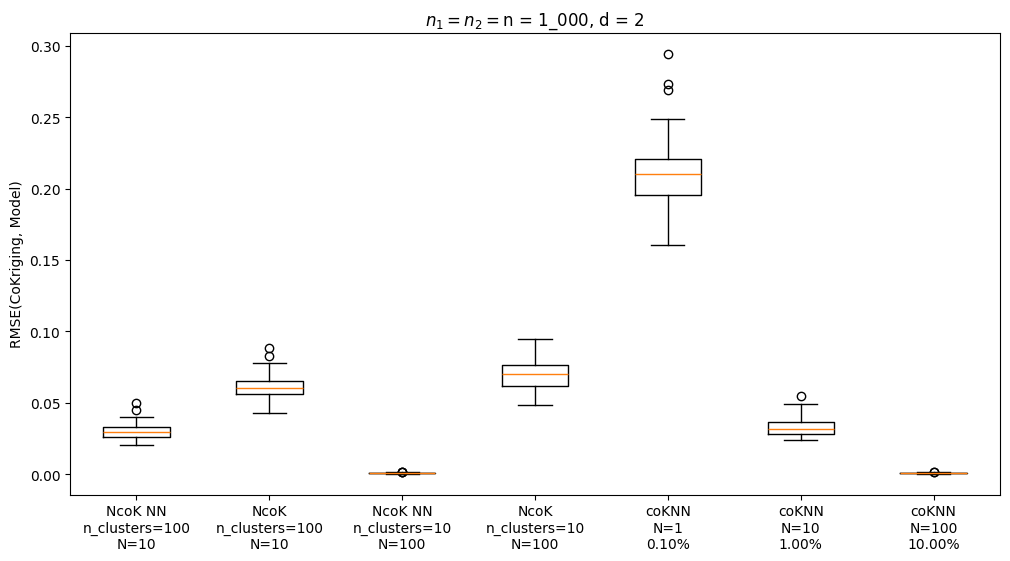

In [33]:
plt.figure(figsize=(12,6))

plt.boxplot(np.hstack([rmses_NcoK, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])
plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

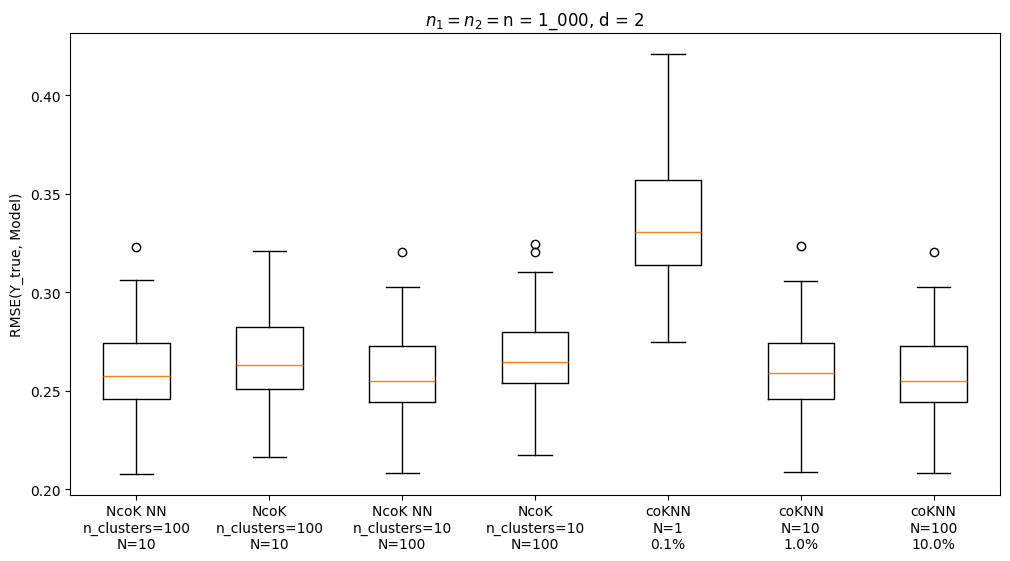

In [34]:
plt.figure(figsize=(12,6))

plt.boxplot(np.hstack([rmses_NcoK_test, rmses_coKNN_test]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.1%}' for N in Ns])
plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

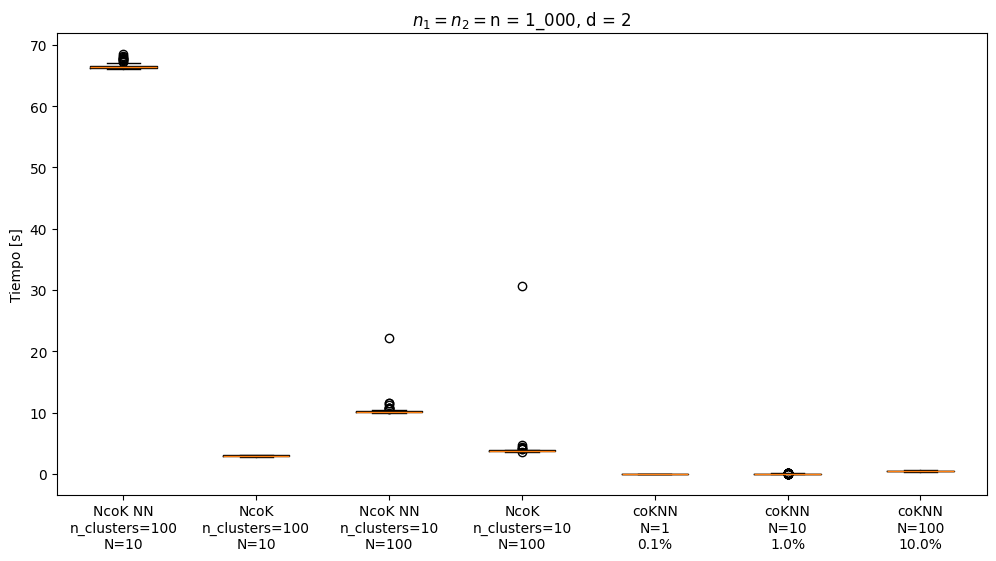

In [37]:
plt.figure(figsize=(12,6))

plt.boxplot(np.hstack([times_NcoK, times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),           
           np.array([(f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}', f'NcoK\n{n_clusters=}\nN={n//n_clusters}') for n_clusters in ns_clusters]).flatten().tolist()
           + [f'coKNN\n{N=}\n{N/n:.1%}' for N in Ns])
plt.ylabel('Tiempo [s]')
plt.title(f'$n_1 = n_2 = ${n = :_.0f}, {d = }');

# BOX PLOTS 

d = 2, nu = 1/2

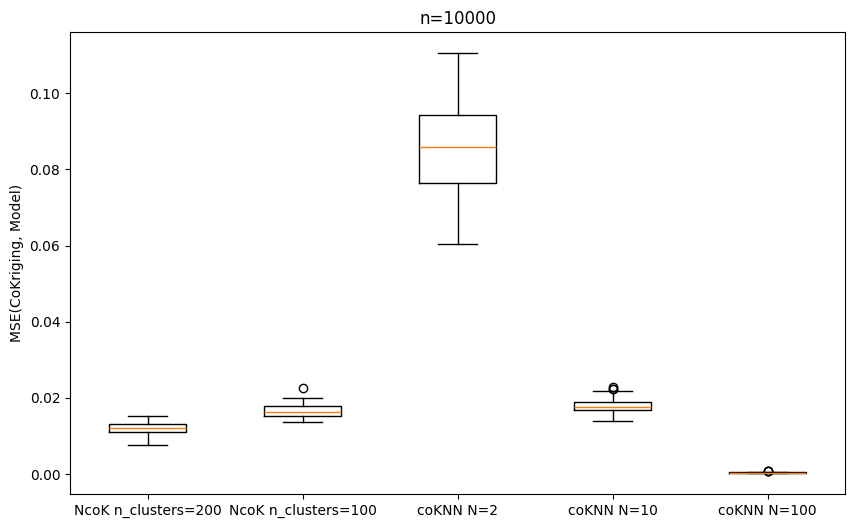

d = 2, nu = 5/2

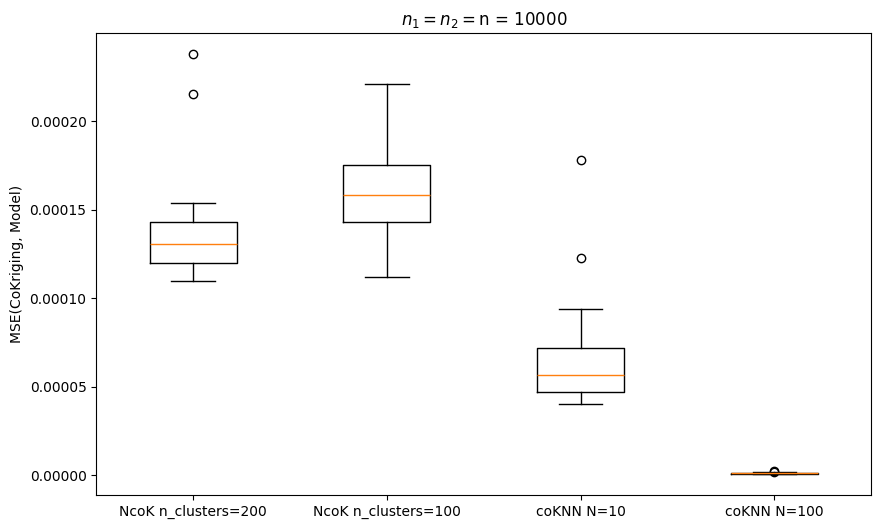